In [ ]:
import re
import urllib
from urllib.request import Request, urlopen
import requests
import os
import time
import json
import pathlib
from urllib.parse import quote
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# Overview

This week is all about working with data. I'm not going to lie to you. This part might be frustrating - but frustration is an integral part of learning. Real data is almost always messy & difficult ... and learning to deal with that fact, is a key part of being a data scientist. 


Enough about the process, let's get to the content. 

![Text](https://raw.githubusercontent.com/suneman/socialgraphs2025/main/files/rock.png "Great image choice, Sune")

Today, we will use network science and Wikipedia to learn about the relationships of **[Rock Bands & Performers](https://en.wikipedia.org/wiki/List_of_mainstream_rock_performers)**. 

To create the network, we will download the Wikipedia pages for all people in the list. Next, we create the network of the pages that link to each other. We can do this because wikipedia pages link to one another. So [The Beatles](https://en.wikipedia.org/wiki/The_Beatles) links to [the Kinks](https://en.wikipedia.org/wiki/The_Kinks), for example.

Next time, we'll use our network skills (as well as new ones) to understand that network. Further down the line, we'll use natural language processing to extract information from the text displayed on those pages.

But for today, the tasks are:

* Learn about regular expressions.
* Download and store (for later use) all the performer-pages from Wikipedia.
* Extract all the internal wikipedia-links that connect the performers on Wikipedia.
* Generate the network of performers on wikipedia.
* Calculate some simple network statistics.
* Create a simple plot

---

# Prelude: Regular expressions

Before we get started, we have to get a little head start on the _Natural Language Processing_ part of the class. This is a new direction for us. Up to now, we've mostly been doing math-y stuff with Python, but today, we're going to be using Python to work through a text. The central thing we need to be able to do today, is to extract internal wikipedia links (links between wiki-pages). And for that we need regular expressions.

<div class="alert alert-block alert-info">
The recipe below is what I told the class to do before LLMs. If you want to try to learn about regular expressions on your own, that's what you need to do. <b>BUT!</b> You don't have to. <b>For this part, it's OK to use an LLM to help you as much as you possibly can.</b> The reason I'm saying this is that I don't think having an intimate knowledge of regular expressions is important for the content of this class.
</div>
<div class="alert alert-block alert-info">
That said, <b>using an LLM means that you have to do extra checking and testing</b>. Make sure that the code you get from your LLM actually does what you asked it to do by going through some examples and manually checking (use a real wiki page or the test-text below). If your LLM hallucinated the wrong answer and you still use the data that comes out, it will count negatively in our evaluations.
</div>

> *Reading/Video*
> * Read [**this tutorial**](https://developers.google.com/edu/python/regular-expressions) to form an overview of regular expressions. This is important to understand the content of the tutorial (also very useful later), so you may actually want to work through the examples. 
> * (**Experiment**: An alternative to reading. If you love videos more than reading, you can also check out [this YouTube explainer video](https://www.youtube.com/watch?v=rhzKDrUiJVk) instead of going through the tutorial above -- it's a friendly looking young man called Kyle who goes through RegExps from his bedroom. I haven't watched the whole thing ... since I personally don't like video explainers ... but it has many views + thumbs up.)

#### **Regular Expressions Tutorial**

Regular expressions are a powerful language for matching text patterns

```match = re.search(pat, str)```

The re.search() method takes a regular expression pattern and a string and searches for that pattern within the string. If the search is successful, search() returns a match object or None otherwise. Therefore, the search is usually immediately followed by an if-statement to test if the search succeeded, as shown in the following example which searches for the pattern 'word:' followed by a 3 letter word (details below):

In [3]:
str = 'an example word:cat!!'
match = re.search(r'word:\w\w\w', str)
# If-statement after search() tests if it succeeded
if match:
  print('found', match.group()) ## 'found word:cat'
else:
  print('did not find')

found word:cat


The code ```match = re.search(pat, str)``` stores the search result in a variable named "match". Then the if-statement tests the match -- if true the search succeeded and match.group() is the matching text (e.g. 'word:cat'). Otherwise if the match is false (None to be more specific), then the search did not succeed, and there is no matching text.

The 'r' at the start of the pattern string designates a python "raw" string which passes through backslashes without change which is very handy for regular expressions (Java needs this feature badly!). I recommend that you always write pattern strings with the 'r' just as a habit.

**Basic Patterns**

The power of regular expressions is that they can specify patterns, not just fixed characters. Here are the most basic patterns which match single chars:

- a, X, 9, < -- ordinary characters just match themselves exactly. The meta-characters which do not match themselves because they have special meanings are: . ^ $ * + ? { [ ] \ | ( ) (details below)
  
- . (a period) -- matches any single character except newline '\n'
- \w -- (lowercase w) matches a "word" character: a letter or digit or underbar [a-zA-Z0-9_]. Note that although "word" is the mnemonic for this, it only matches a single word char, not a whole word. \W (upper case W) matches any non-word character.
- \b -- boundary between word and non-word
- \s -- (lowercase s) matches a single whitespace character -- space, newline, return, tab, form [ \n\r\t\f]. \S (upper case S) matches any non-whitespace character.
- \t, \n, \r -- tab, newline, return
- \d -- decimal digit [0-9] (some older regex utilities do not support \d, but they all support \w and \s)
- ^ = start, $ = end -- match the start or end of the string
- \ -- inhibit the "specialness" of a character. So, for example, use \. to match a period or \\ to match a slash. If you are unsure if a character has special meaning, such as '@', you can try putting a slash in front of it, \@. If its not a valid escape sequence, like \c, your python program will halt with an error.

**Basic Examples**

*Joke: what do you call a pig with three eyes? piiig!*

The basic rules of regular expression search for a pattern within a string are:

- The search proceeds through the string from start to end, stopping at the first match found
- All of the pattern must be matched, but not all of the string
- If ```match = re.search(pat, str)``` is successful, match is not None and in particular match.group() is the matching text

In [4]:
# Search for pattern 'iii' in string 'piiig'.
# All of the pattern must match, but it may appear anywhere.
# On success, match.group() is matched text.
match = re.search(r'iii', 'piiig') # found, match.group() == "iii"
match = re.search(r'igs', 'piiig') # not found, match == None

# . = any char but \n
match = re.search(r'..g', 'piiig') # found, match.group() == "iig"

# \d = digit char, \w = word char
match = re.search(r'\d\d\d', 'p123g') # found, match.group() == "123"
match = re.search(r'\w\w\w', '@@abcd!!') # found, match.group() == "abc"

**Repetition**

Things get more interesting when you use + and * to specify repetition in the pattern

- \+ -- 1 or more occurrences of the pattern to its left, e.g. 'i+' = one or more i's
- \* -- 0 or more occurrences of the pattern to its left
- ? -- match 0 or 1 occurrences of the pattern to its left

**Leftmost & Largest**

First the search finds the leftmost match for the pattern, and second it tries to use up as much of the string as possible -- i.e. + and * go as far as possible (the + and * are said to be "greedy").

In [5]:
# i+ = one or more i's, as many as possible.
match = re.search(r'pi+', 'piiig') # found, match.group() == "piii"

# Finds the first/leftmost solution, and within it drives the +
# as far as possible (aka 'leftmost and largest').
# In this example, note that it does not get to the second set of i's.
match = re.search(r'i+', 'piigiiii') # found, match.group() == "ii"

# \s* = zero or more whitespace chars
# Here look for 3 digits, possibly separated by whitespace.
match = re.search(r'\d\s*\d\s*\d', 'xx1 2   3xx') # found, match.group() == "1 2   3"
match = re.search(r'\d\s*\d\s*\d', 'xx12  3xx') # found, match.group() == "12  3"
match = re.search(r'\d\s*\d\s*\d', 'xx123xx') # found, match.group() == "123"

# ^ = matches the start of string, so this fails:
match = re.search(r'^b\w+', 'foobar') # not found, match == None
# but without the ^ it succeeds:
match = re.search(r'b\w+', 'foobar') # found, match.group() == "bar"

**Emails Example**

Suppose you want to find the email address inside the string 'xyz alice-b@google.com purple monkey'. We'll use this as a running example to demonstrate more regular expression features. Here's an attempt using the pattern r'\w+@\w+':

In [6]:
str = 'purple alice-b@google.com monkey dishwasher'
match = re.search(r'\w+@\w+', str)
if match:
    print(match.group())  # 'b@google'
# Failes to find the full email adress  

b@google


The search does not get the whole email address in this case because the \w does not match the '-' or '.' in the address. We'll fix this using the regular expression features below.

**Square Brackets** 

Square brackets can be used to indicate a set of chars, so [abc] matches 'a' or 'b' or 'c'. The codes \w, \s etc. work inside square brackets too with the one exception that dot (.) just means a literal dot. For the emails problem, the square brackets are an easy way to add '.' and '-' to the set of chars which can appear around the @ with the pattern r'[\w.-]+@[\w.-]+' to get the whole email address:

In [7]:
str = 'purple alice-b@google.com monkey dishwasher'
match = re.search(r'[\w.-]+@[\w.-]+', str)
if match:
    print(match.group())  # 'alice-b@google.com'

alice-b@google.com


(More square-bracket features) You can also use a dash to indicate a range, so [a-z] matches all lowercase letters. To use a dash without indicating a range, put the dash last, e.g. [abc-]. An up-hat (^) at the start of a square-bracket set inverts it, so [^ab] means any char except 'a' or 'b'.

**Group Extraction**

The "group" feature of a regular expression allows you to pick out parts of the matching text. Suppose for the emails problem that we want to extract the username and host separately. To do this, add parentheses ( ) around the username and host in the pattern, like this: r'([\w.-]+)@([\w.-]+)'. In this case, the parentheses do not change what the pattern will match, instead they establish logical "groups" inside of the match text. On a successful search, match.group(1) is the match text corresponding to the 1st left parentheses, and match.group(2) is the text corresponding to the 2nd left parentheses. The plain match.group() is still the whole match text as usual.

**A common workflow with regular expressions is that you write a pattern for the thing you are looking for, adding parentheses groups to extract the parts you want.**

In [8]:
str = 'purple alice-b@google.com monkey dishwasher'
match = re.search(r'([\w.-]+)@([\w.-]+)', str)
if match:
    print(match.group())   # 'alice-b@google.com' (the whole match)
    print(match.group(1))  # 'alice-b' (the username, group 1)
    print(match.group(2))  # 'google.com' (the host, group 2)

alice-b@google.com
alice-b
google.com


**findall**

```findall()``` is probably the single most powerful function in the re module. Above we used re.search() to find the first match for a pattern. findall() finds *all* the matches and returns them as a list of strings, with each string representing one match.

In [9]:
# Suppose we have a text with many email addresses
str = 'purple alice@google.com, blah monkey bob@abc.com blah dishwasher'

# Here re.findall() returns a list of all the found email strings
emails = re.findall(r'[\w\.-]+@[\w\.-]+', str) ## ['alice@google.com', 'bob@abc.com']
for email in emails:
    # do something with each found email string
    print(email)

alice@google.com
bob@abc.com


**findall With Files**

For files, you may be in the habit of writing a loop to iterate over the lines of the file, and you could then call findall() on each line. Instead, let findall() do the iteration for you -- much better! Just feed the whole file text into findall() and let it return a list of all the matches in a single step (recall that f.read() returns the whole text of a file in a single string):

In [10]:
# Open file
f = open('test.txt', encoding='utf-8')
# Feed the file text into findall(); it returns a list of all the found strings
strings = re.findall(r'some pattern', f.read())

**findall and Groups**

The parentheses ( ) group mechanism can be combined with findall(). If the pattern includes 2 or more parentheses groups, then instead of returning a list of strings, findall() returns a list of *tuples*. Each tuple represents one match of the pattern, and inside the tuple is the group(1), group(2) .. data. So if 2 parentheses groups are added to the email pattern, then findall() returns a list of tuples, each length 2 containing the username and host, e.g. ('alice', 'google.com').

In [11]:
str = 'purple alice@google.com, blah monkey bob@abc.com blah dishwasher'
tuples = re.findall(r'([\w\.-]+)@([\w\.-]+)', str)
print(tuples)  # [('alice', 'google.com'), ('bob', 'abc.com')]
for tuple in tuples:
    print(tuple[0])  # username
    print(tuple[1])  # host

[('alice', 'google.com'), ('bob', 'abc.com')]
alice
google.com
bob
abc.com


Once you have the list of tuples, you can loop over it to do some computation for each tuple. If the pattern includes no parentheses, then findall() returns a list of found strings as in earlier examples. If the pattern includes a single set of parentheses, then findall() returns a list of strings corresponding to that single group. (Obscure optional feature: Sometimes you have paren ( ) groupings in the pattern, but which you do not want to extract. In that case, write the parens with a ?: at the start, e.g. (?: ) and that left paren will not count as a group result.)

**RE Workflow and Debug**

Regular expression patterns pack a lot of meaning into just a few characters , but they are so dense, you can spend a lot of time debugging your patterns. Set up your runtime so you can run a pattern and print what it matches easily, for example by running it on a small test text and printing the result of findall(). If the pattern matches nothing, try weakening the pattern, removing parts of it so you get too many matches. When it's matching nothing, you can't make any progress since there's nothing concrete to look at. Once it's matching too much, then you can work on tightening it up incrementally to hit just what you want.

**Options**

The re functions take options to modify the behavior of the pattern match. The option flag is added as an extra argument to the search() or findall() etc., e.g. re.search(pat, str, re.IGNORECASE).

- IGNORECASE -- ignore upper/lowercase differences for matching, so 'a' matches both 'a' and 'A'.
- DOTALL -- allow dot (.) to match newline -- normally it matches anything but newline. This can trip you up -- you think .* matches everything, but by default it does not go past the end of a line. Note that \s (whitespace) includes newlines, so if you want to match a run of whitespace that may include a newline, you can just use \s*
- MULTILINE -- Within a string made of many lines, allow ^ and $ to match the start and end of each line. Normally ^/\$ would just match the start and end of the whole string.

**Greedy vs. Non-Greedy (optional)**

This is optional section which shows a more advanced regular expression technique not needed for the exercises.

Suppose you have text with tags in it: \<b>foo\</b> and \<i>so on\</i>

Suppose you are trying to match each tag with the pattern '(<.*>)' -- what does it match first?

The result is a little surprising, but the greedy aspect of the .* causes it to match the whole '\<b>foo\</b> and \<i>so on\</i>' as one big match. The problem is that the .* goes as far as is it can, instead of stopping at the first > (aka it is "greedy").

There is an extension to regular expression where you add a ? at the end, such as .\*? or .+?, changing them to be non-greedy. Now they stop as soon as they can. So the pattern '(<.\*?>)' will get just '\<b>' as the first match, and '\</b>' as the second match, and so on getting each <..> pair in turn. The style is typically that you use a .\*? immediately followed by some concrete marker (> in this case) to which the .*? run is forced to extend.

The *? extension originated in Perl, and regular expressions that include Perl's extensions are known as Perl Compatible Regular Expressions -- pcre. Python includes pcre support. Many command line utils etc. have a flag where they accept pcre patterns.

An older but widely used technique to code this idea of "all of these chars except stopping at X" uses the square-bracket style. For the above you could write the pattern, but instead of .* to get all the chars, use [^>]* which skips over all characters which are not > (the leading ^ "inverts" the square bracket set, so it matches any char not in the brackets).

**Substitution (optional)**

The ```re.sub(pat, replacement, str)``` function searches for all the instances of pattern in the given string, and replaces them. The replacement string can include '\1', '\2' which refer to the text from group(1), group(2), and so on from the original matching text.

Here's an example which searches for all the email addresses, and changes them to keep the user (\1) but have yo-yo-dyne.com as the host.

In [12]:
str = 'purple alice@google.com, blah monkey bob@abc.com blah dishwasher'
# re.sub(pat, replacement, str) -- returns new string with all replacements,
# \1 is group(1), \2 group(2) in the replacement
print(re.sub(r'([\w\.-]+)@([\w\.-]+)', r'\1@yo-yo-dyne.com', str))
# purple alice@yo-yo-dyne.com, blah monkey bob@yo-yo-dyne.com blah dishwasher

purple alice@yo-yo-dyne.com, blah monkey bob@yo-yo-dyne.com blah dishwasher


#### **Exercises: Regular expressions round**

> _Exercises_: Regular expressions round 1\.
> * Now, explain in your own words: what are regular expressions?
>   - **ANSWER**: Its a tool to search for patterns in text. It can be used to find specific parts of a text (and digits).

> * Provide an example of a regex to match 4 digits numbers (by this, I mean precisely 4 digits, you should not match any part of numbers with e.g. 5 digits). In your notebook, use `findall` to show that your regex works on this [test-text](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt). **Hint**: a great place to test out regular expressions is: https://regex101.com.

In [13]:
# Open file
f = open('test.txt', encoding='utf-8')

# Feed the file text into findall(); it returns a list of all the found strings
strings = re.findall(r'[0-9]{4}', f.read())
for string in strings:
    print(string)

1234
9999
2345


> * Provide an example of a regex to match words starting with "super". Show that it works on the [test-text](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/regex_exercise.txt).

In [14]:
# Open file
f = open('test.txt', encoding='utf-8')
strings = re.findall(r'super\w*', f.read())
for string in strings:
    print(string)

superpolaroid
supertaxidermy
superbeer


Now we can go on to figure out how how to match internal wiki links. Wiki links come in two flavors. They're always enclosed in double square brackets, e.g. `[[wiki-link]]` and can either occur like this:

    ... some text [[Aristotle]] some more text ...

which links to the page [`https://en.wikipedia.org/wiki/Aristotle`](https://en.wikipedia.org/wiki/Aristotle). 

The second flavor has two parts, so that links can handle spaces and other more fancy forms of references, here's an example:

    ... some text [[John_McCain|John McCain]] some more text ...

which links to the page [`https://en.wikipedia.org/wiki/John_McCain`](https://en.wikipedia.org/wiki/John_McCain). Now it's your turn.

> _Exercise_: Regular expressions round 2\. Show that you can extract the wiki-links from the [test-text](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/master/files/regex_exercise.txt). Perhaps you can find inspiration on stack overflow or similar. **Hint**: Try to solve this exercise on your own (that's what you will get the most out of - learning wise), but if you get stuck ... you will find the solution in one of the video lectures below.
> 

In [15]:
# Open file
f = open('test.txt', encoding='utf-8')
strings = re.findall(r'(\[\[(.*?)\]\])', f.read())
for string in strings:
    print(string[0])
    #print(string[1]) # Without the [[]]

[[drinking vinegar]]
[[gentrify]]
[[hashtag]]
[[Bicycle|Bicycle(two-wheeled type)]]
[[Pitchfork|Pitchfork Magazine]]


---

# Part 1: Download the Wikipedia pages of characters

It's time to download all of the pages of the characters. Use your experience with APIs from Week 1\. To get started, I **strongly** recommend that you re-watch the **APIs video lecture** from that week - it contains lots of useful tips on this specific activity (yes, I had planned this all along!). I've included it below for your covenience.

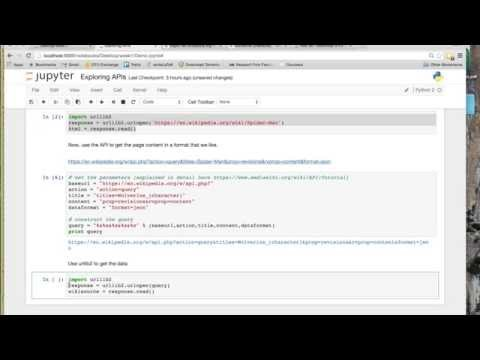

In [16]:
from IPython.display import YouTubeVideo
YouTubeVideo("9l5zOfh0CRo",width=800, height=450)

Now, it's time to go and get the names of all the wiki pages you'll need for your analysis. Those will serve as the nodes in our network. 

*Exercise*
> * Go to the page https://en.wikipedia.org/wiki/List_of_mainstream_rock_performers and extract all of the artist-links using your regular expressions from above.
>   * Hint: To make this easier, you can simply hit the edit button on wikipedia, copy the entire content of the file to a plain text file on your computer and manually delete all of the markup that's not related to the artists' names. (Otherwise there are some wiki-links there that you don't want)

<div class="alert alert-block alert-info">
Again, it's OK to use an LLM as much as you can here. But you should double check that it actually does what you want and all that stuff.
</div>

In [17]:
# Open file
f = open('list_of_mainstream_rock_performers.txt', encoding='utf-8')
links = re.findall(r'(\[\[(.*?)\]\])', f.read())
for link in links:
    print(link[0])
    # print(link[1]) # Without the [[]] 
len(links)

[[10cc]]
[[10 Years (band)|10 Years]]
[[3 Doors Down]]
[[311 (band)|311]]
[[38 Special (band)|.38 Special]]
[[ABBA]]
[[Accept (band)|Accept]]
[[AC/DC]]
[[Bryan Adams]]
[[Aerosmith]]
[[AFI (band)|AFI]]
[[Air Supply]]
[[The Alan Parsons Project]]
[[Alice in Chains]]
[[The All-American Rejects]]
[[The Allman Brothers Band]]
[[Alter Bridge]]
[[Ambrosia (band)|Ambrosia]]
[[America (band)|America]]
[[The Animals]]
[[Adam Ant]]
[[Anthrax (American band)|Anthrax]]
[[April Wine]]
[[Arcade Fire]]
[[Arctic Monkeys]]
[[Asia (band)|Asia]]
[[Audioslave]]
[[Avenged Sevenfold]]
[[Awolnation]]
[[The B-52's|The B-52s]]
[[Bachman–Turner Overdrive]]
[[Bad Company]]
[[Badfinger]]
[[The Band]]
[[The Bangles]]
[[Barenaked Ladies]]
[[Bay City Rollers]]
[[The Beach Boys]]
[[Beastie Boys]]
[[The Beatles]]
[[Bee Gees]]
[[Beck]]
[[Ben Folds Five]]
[[Pat Benatar]]
[[Chuck Berry]]
[[The Big Bopper]]
[[Billy Talent]]
[[The Black Crowes]]
[[The Black Keys]]
[[Black Sabbath]]
[[Black Stone Cherry]]
[[Black Veil Brides

489

#### A note to the perfectionists out there
The files contain names and corresponding wiki-link, but pages can be missing or redirected. If you encounter re-directs, you can follow the redirect link and see if you can recover a page that's not already in your database.  (But you do not have to do that either - it's fine to just skip ... many new issues can arise if you try to follow the redirects).

#### Back to our regularly scheduled programming

With the list from the exercise above, you now have all of the nodes in the network.

*Exercise*

> * Use your knowledge of APIs and the list of all the wiki-pages to download all the text on the pages of the country performers. 
>   - Hint 0: Make sure you read the [Wiki API pages](https://www.mediawiki.org/wiki/API:Main_page) to ensure that your **download the cleanest possible version of the page (the wikitext)**. [This link](https://stackoverflow.com/questions/55779015/get-wikitext-from-wikipedia-api) may be helpful.
>   - Hint 1: You may want to save the individual band/artist pages on your computer. You can use your skills from the first lectures to write them as plain-text files (that's what I would do - one file per band/artist, named according to its wiki-link). (But you can also use pickle files or start a database if you like that better.)
>   - Hint 2: If you now have a directory with all those files, you can use [`os.listdir()`](https://www.geeksforgeeks.org/python-os-listdir-method/) to list all the files in that directory within Python and iterate over the files if you need to.
>   - Hint 3: Don't forget to add underscores to the performer names when you construct the urls

<div class="alert alert-block alert-info">
Again, it's OK to use an LLM here.
</div>

In [18]:
url = 'https://en.wikipedia.org/wiki/List_of_mainstream_rock_performers'
headers = {"User-Agent" : "MyWikipediaClient/1.0 (example@example.com)"} # just use this dict as-is.
response = requests.get(url, headers=headers)
print(f'Status code: {response.status_code}')

Status code: 200


In [19]:
"""
========================
MEDIAWIKI HARVESTER (annotated)
========================

Change these when you reuse the script:

- API:        The MediaWiki API endpoint. For any MediaWiki site, this is usually
              https://<host>/w/api.php   (Wikipedia, Wiktionary, fandom wikis, etc.)
- LIST_PAGE:  The title of the page that *contains links* to the pages you want.
- PLNAMESPACE:Which namespace to pull links from. 0 = main articles (usually what you want).
- WHAT_TO_GET:Choose between "wikitext" (raw markup), "plaintext" (no markup), or "html".

Optional tweaks:
- HEADERS:    Put a descriptive User-Agent with contact (api etiquette).
- OUTDIR:     Output folder name.
- THROTTLE:   Sleep between requests (be nice to servers).
- FOLLOW_REDIRECTS: Resolve redirects automatically.
"""

# -------------------------
# KNOBS (edit these)
# -------------------------
API = "https://en.wikipedia.org/w/api.php"          # MediaWiki API endpoint
LIST_PAGE = "List_of_mainstream_rock_performers"    # The “index” page to mine links from
PLNAMESPACE = 0                                     # 0=articles, 14=categories, etc.
WHAT_TO_GET = "wikitext"                            # "wikitext" | "plaintext" | "html"
OUTDIR = pathlib.Path("performers_wikitext")        # Where files go
THROTTLE = 0.1                                      # seconds sleep between page fetches
FOLLOW_REDIRECTS = True                             # follow redirects when fetching pages

# Good API citizenship: identify your client + contact
HEADERS = {"User-Agent": "MainstreamRockHarvester/1.1 (your_email@example.com)"}

# A single session keeps connections alive (faster + friendlier)
SESSION = requests.Session()

OUTDIR.mkdir(exist_ok=True)


def wiki_get(params):
    """
    Core GET helper:
    - Adds format=json
    - Retries politely if server is under replication lag ("maxlag")
    - Raises for HTTP errors
    Change timeout/retry policy here if needed.
    """
    params = {**params, "format": "json"}
    for _ in range(5):
        r = SESSION.get(API, params=params, headers=HEADERS, timeout=30)
        r.raise_for_status()
        data = r.json()
        # MediaWiki asks heavy clients to back off when replicas lag; respect it
        if "error" in data and data["error"].get("code") == "maxlag":
            time.sleep(2)
            continue
        return data
    raise RuntimeError("Too many retries / maxlag")


def list_article_links(title):
    """
    Collects all *article* (namespace PLNAMESPACE) links from a page.
    Reusable pattern for any list page on any MediaWiki:
    - action=query
    - prop=links
    - titles=<your list page>
    - plnamespace=<target namespace>
    - handle 'plcontinue' to get all results
    """
    titles = []
    plcontinue = None

    while True:
        params = {
            "action": "query",
            "prop": "links",
            "titles": title,
            "plnamespace": PLNAMESPACE,
            "pllimit": "max",
        }
        if plcontinue:
            params["plcontinue"] = plcontinue

        data = wiki_get(params)

        # pages is a dict keyed by pageid; we just need the 'links' arrays
        for page in data["query"]["pages"].values():
            for link in page.get("links", []):
                titles.append(link["title"])

        # continuation key means "more pages to fetch"
        plcontinue = data.get("continue", {}).get("plcontinue")
        if not plcontinue:
            break

    # de-duplicate while preserving order
    seen, ordered = set(), []
    for t in titles:
        if t not in seen:
            seen.add(t)
            ordered.append(t)
    return ordered


def title_to_filename(title):
    """
    Turns a wiki title into a safe filename.
    MediaWiki titles can include ':', '/', etc.—replace anything unfriendly.
    """
    name = title.replace(" ", "_")
    name = re.sub(r'[\\/:"*?<>|]+', "_", name)
    return f"{name}.txt"


def fetch_content(title):
    """
    Fetch the page content according to WHAT_TO_GET:

    - wikitext:  action=query&prop=revisions&rvprop=content&rvslots=main
    - plaintext: action=query&prop=extracts&explaintext=1
    - html:      action=parse&prop=text

    Set FOLLOW_REDIRECTS=True to resolve redirects automatically.
    """
    if WHAT_TO_GET == "wikitext":
        params = {
            "action": "query",
            "prop": "revisions",
            "titles": title,
            "rvprop": "content",
            "rvslots": "main",
            "formatversion": "2",
        }
        if FOLLOW_REDIRECTS:
            params["redirects"] = "1"
        data = wiki_get(params)
        pages = data["query"]["pages"]
        if not pages or pages[0].get("missing"):
            return None
        revs = pages[0].get("revisions", [])
        if not revs:
            return None
        return revs[0]["slots"]["main"]["content"]

    elif WHAT_TO_GET == "plaintext":
        params = {
            "action": "query",
            "prop": "extracts",
            "titles": title,
            "explaintext": "1",     # strip markup to plain text
            "formatversion": "2",
        }
        if FOLLOW_REDIRECTS:
            params["redirects"] = "1"
        data = wiki_get(params)
        pages = data["query"]["pages"]
        if not pages or pages[0].get("missing"):
            return None
        return pages[0].get("extract", "")

    elif WHAT_TO_GET == "html":
        params = {
            "action": "parse",
            "page": title,
            "prop": "text",         # returns HTML string
            "formatversion": "2",
            "redirects": "true" if FOLLOW_REDIRECTS else "false",
        }
        data = wiki_get(params)
        return data.get("parse", {}).get("text", "")

    else:
        raise ValueError(f"Unknown WHAT_TO_GET: {WHAT_TO_GET}")


def main():
    print(f"Collecting titles from: {LIST_PAGE}")
    titles = list_article_links(LIST_PAGE)
    print(f"Found {len(titles)} candidate pages.")

    for i, title in enumerate(titles, 1):
        fn = OUTDIR / title_to_filename(title)
        if fn.exists():   # resume-friendly: skip already saved files
            continue

        content = fetch_content(title)
        if not content:
            print(f"[{i}/{len(titles)}] MISSING or empty: {title}")
            continue

        fn.write_text(content, encoding="utf-8")
        if i % 25 == 0:
            print(f"Saved {i}/{len(titles)}…")

        time.sleep(THROTTLE)  # be polite

    print("Done. Files are in:", OUTDIR.resolve())


if __name__ == "__main__":
    main()

Found 490 candidate pages.
Done. Files are in: C:\Users\henri\Documents\Human-Centered_Artificial_Intelligence_MSc\Social_Graphs\week-4\performers_wikitext


---

# Part 2: Building the networks

Now, we're going to build a single NetworkX directed graph with all the rock performers. (We are analyzing a network of bands/artists/perfomers. I'll use all of those interchangably below). 

The nodes in the network will be all the performers, and we will place an edge between nodes $A$ and $B$ if the Wikipedia page of node $A$ links to the Wikipedia page of node $B$.

The overall plan of attack for this is the following: 
* Take the pages you have downloaded for each performer. 
* Each page corresponds to a performer (= a node in your network). 
* Find all the links in a performers page that link to another node of the network (= some other performer). 
* There are many ways to do this, but below, I've tried to break it down into natural steps. 


*Exercise*: Build the network of Rock Performers 

> Now we can build the network. Here are the instructions.
>
>
> * Use a regular expression to extract all outgoing links from each of the pages you downloaded above. 
>   - Start by making a single page work. Do some debugging to make sure it's actually working.
>   - Then slowly build the loops over performers/pages to take your little operation to industrial scale
>   - You don't have to be perfect. There will be tricky edge-cases, you don't have to solve all of those. The key is to get a pretty good network to work with, not to make everything perfect.
> * For each link you extract, check if the target is a person from your list of performers. If yes, keep it. If no, discard it.
> * Use a NetworkX [`DiGraph`](https://networkx.org/documentation/stable/reference/classes/digraph.html) to store the network.
> * Store the `length of the content` as an attribute of the node (i.e. count the number of *words* you have in each character's page). By storing this information as a nodal features, we keep all the relevant data in one place. The safe way to count words without counting symbols is to use `regex`, but simpler methods are OK.
> * When have you finished, you'll notice that some nodes do not have any out- and in- degrees. Unless you've made a mistake, those are truly isolated bands/singers. Double check for mistakes, then *discard* those disconnected nodes from the network.
> * Finally, extract the largest component - it will make our work with visualisations much easier (note: removing *isolated* nodes (with no links) does not guarantee that you are left with the largest component).
>     - *Note 1*: For directed graphs use `weakly connected component` to extract the largest component. You can also check the hints on how to extract the largest component of a graph from Week 1 notebook.
>     - *Note 2*: Further analysis is done with the largest component.

Take a moment to think about what you have just accomplished! Using simple tools, you've managed to build a complex network by crawling data from wikipedia. This means that you are a powerful hacker. Congratulations.

<div class="alert alert-block alert-info">
If it's helpful to you, it's OK to use an LLM here.
</div>


In [ ]:
# Setup, helpers, and file mapping (nodes = performers)
# ---- Paths ----
FOLDER = Path("performers_wikitext")                 # where all *.txt pages live
INDEX  = Path("list_of_mainstream_rock_performers.txt")  # optional list page (in notebook folder)

assert FOLDER.exists(), f"Folder not found: {FOLDER.resolve()}"

# ---- Helper: extract unique internal wikilink TARGETS from wikitext ----
def wikilink_targets(text: str):
    titles = re.findall(r'\[\[([^\]|#]+)', text)          # target before '|' or '#'
    titles = [t.strip() for t in titles if ":" not in t]  # drop namespaces (Category:, File:, ...)
    seen, out = set(), []
    for t in titles:
        t = t.replace("_", " ")
        if t not in seen:
            seen.add(t); out.append(t)
    return out

# ---- If we have the index file, use it to define the node set (safer). Otherwise use all files ----
def canon(s: str) -> str:
    s = s.replace(" ", "_")
    s = re.sub(r'[\\/:"*?<>|]+', "_", s)
    return s.lower()

if INDEX.exists():
    index_titles = wikilink_targets(INDEX.read_text(encoding="utf-8"))
    index_by_key = {canon(t): t for t in index_titles}
    files_by_key = {canon(p.stem): p for p in FOLDER.glob("*.txt")}
    common_keys  = index_by_key.keys() & files_by_key.keys()
    file_for_title = {index_by_key[k]: files_by_key[k] for k in common_keys}
else:
    file_for_title = {p.stem.replace("_"," "): p for p in FOLDER.glob("*.txt")}

performers = set(file_for_title)  # official titles we’ll use as nodes

print("Pages folder:", FOLDER.resolve())
print("Using index :", INDEX.name if INDEX.exists() else "(none)")
print("Performers (nodes) available:", len(performers))
import networkx as nx
import matplotlib.pyplot as pltprint("Example titles:", sorted(list(file_for_title))[:5])

Pages folder: C:\Users\henri\Documents\Human-Centered_Artificial_Intelligence_MSc\Social_Graphs\week-4\performers_wikitext
Using index : list_of_mainstream_rock_performers.txt
Performers (nodes) available: 489
Example titles: ['10 Years (band)', '10cc', '3 Doors Down', '311 (band)', '38 Special (band)']


In [23]:
# build the directed graph (edges = performer→performer links)
def word_count(s: str) -> int:
    return len(re.findall(r"\b\w+\b", s))  # count words, ignore punctuation

G = nx.DiGraph()

for src_title, path in file_for_title.items():
    text = path.read_text(encoding="utf-8")
    # node with attribute: length of content
    G.add_node(src_title, n_words=word_count(text))
    # edges to other performers found in this page's links
    targets = [t for t in wikilink_targets(text) if t in performers and t != src_title]
    for dst_title in targets:
        G.add_edge(src_title, dst_title)

print(f"Built graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Built graph: 489 nodes, 7688 edges


In [24]:
# prune isolated nodes and extract the largest weakly connected component
isolated = [n for n in G if G.in_degree(n)==0 and G.out_degree(n)==0]
G.remove_nodes_from(isolated)

# largest component (treat edges as undirected for connectivity)
components = list(nx.weakly_connected_components(G))
H = G.subgraph(max(components, key=len)).copy()

print("Isolates removed:", len(isolated))
print("Largest component:", H.number_of_nodes(), "nodes,", H.number_of_edges(), "edges")

Isolates removed: 4
Largest component: 485 nodes, 7688 edges


*Excercise*: 
> * Document how you crawled the network.
>    * First, simply describe the steps of the process (what you did, step by step)
>    * Then, write a short section about which part of the process that was most difficult
>    * Next write a short section about how you used LLMs to help you
>    * Finally, compose a short section about what you would do differently if you had to do it again
<div class="alert alert-block alert-info">
Use your own words here. Writing makes you better at thinking! Train that brain.
</div>

**ANSWER**:

**Step-by-step process:**
-  Collected pages:
   -  sed the MediaWiki API to get all article links from “List of mainstream rock performers.”
   -  Downloaded each performer’s page wikitext and saved one file per page in ```performers_wikitext/Title.txt``` directory.
-  Parsed outgoing links:
   - From each file, extracted internal links with a regex that keeps the target before ```|``` or ```#``` ```->``` ```[[Target|label]] → Target```
   - Ignored namespaced links (e.g. ```File:```, ```Category:```, etc.)
   - Normalized titles (underscores → spaces) and de-duplicated links per page.
 - Built the directed graph:
   - Nodes = performer titles (taken from filenames).
   - Added node attribute ```n_words``` = number of words in the page (counted with regex). Because some pages were missing, ```n_words``` is 0 for those nodes.
   - Added an edge A → B when A’s page links to B and B is also in the performer set.
 - Cleaned and focused:
   - Removed isolated nodes (no in- or out-links)
   - Kept the largest weakly connected component for analysis/plots.
 - Quick analysis:
   - Drew a spring-layout plot with node size scaled by degree.
   - Plotted in-degree and out-degree histograms to see hubs and tails.
  
**Most difficult part:**
- Link parsing edge cases: Links appear as ```[[Title]]```, ```[[Title|label]]```, ```[[Title#Section|label]]```, etc. Needed to grab only the target title and skip namespaces.
- Filtering to performers: Many links go to albums, places, labels. Solved by intersecting extracted titles with my performer title set. 
- Graph cleaning: Without per-page de-duplication you get parallel edges; without pruning isolates the visualization is noisy.

**How I used LLMs:**
- Helped pick the right MediaWiki endpoints (```prop=links```, ```prop=revisions```) and handled pagination (```plcontinue```) and polite retries (```maxlag```) in the API calls.
- Co-designed the regex to extract ```[[Target]]``` robustly and igonore namespaces/sections.
- Structured the pipeline into clear stages: data collection, link extraction, graph building, cleaning, analysis.
- Troubleshot path issues, sanity checks.

**What I would do differently:**
- Resolve redirects/aliases: Enabled by ```redirects=1``` and unify titles so edges aren't split across name variants. 
- Edge weights: Count repeated A→B mentions and store as ```weight``` on edges.

*Exercise*: Simple network statistics and analysis

> * What is the number of nodes in the network? 
> * More importantly, what is the number of links? (Chat with a fellow student or a TA to make sure you're in the right ball-park)
> * Plot the in and out-degree distributions for the entire network. What do you observe? Can you explain why the in-degree distribution is different from the out-degree distribution?
>     * Compare the out-degree distribution to a *random network* with the same number of nodes and links.
>     * Compare the in-degree distribution to a *scale-free* network with the same number of nodes.
> * Who are the top 5 most connected performers (Report results for in-degrees and out-degrees, that is, who has highest in-degree, who has highest out-degree)? Comment on your findings. Is this what you would have expected?
> * What are the 10 pages with the longest wiki entries? (use the `length of content` attribute to figure this one out)?

<div class="alert alert-block alert-info">
For this exercise, I hope you'll do everything yourself. This is a part where you learn something by writing the code.
</div>

In [26]:
# Number of nodes in the network and links
print("All nodes/edges:", G.number_of_nodes(), G.number_of_edges())
print("After removing isolates:", G.number_of_nodes(), G.number_of_edges())
print("Largest component:", H.number_of_nodes(), H.number_of_edges())

All nodes/edges: 485 7688
After removing isolates: 485 7688
Largest component: 485 7688


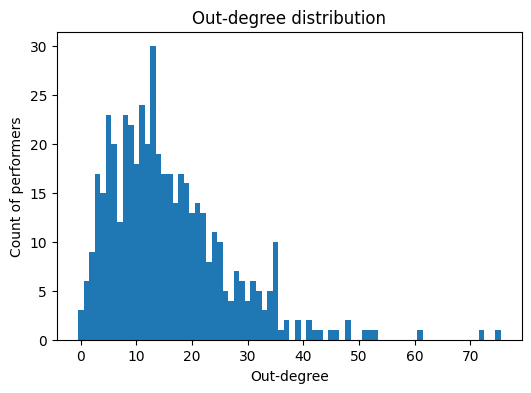

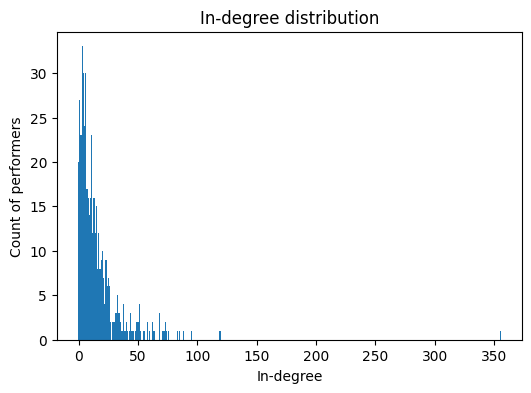

In [27]:
# Plot in and out-degree distributions (who links a lot?)
outdeg = [d for _, d in H.out_degree()]
indeg  = [d for _, d in H.in_degree()]

plt.figure(figsize=(6,4))
plt.hist(outdeg, bins=range(0, max(outdeg)+2), align="left")
plt.xlabel("Out-degree")
plt.ylabel("Count of performers")
plt.title("Out-degree distribution")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(indeg, bins=range(0, max(indeg)+2), align="left")
plt.xlabel("In-degree")
plt.ylabel("Count of performers")
plt.title("In-degree distribution")
plt.show()

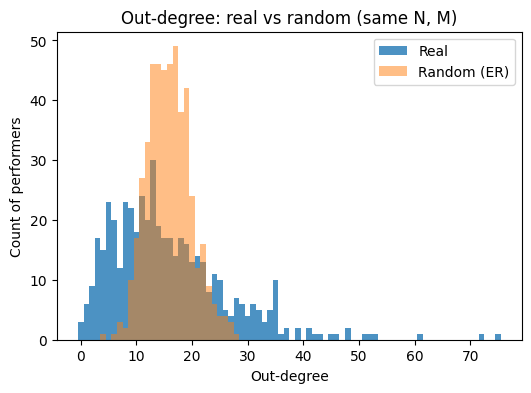

In [31]:
# Compare your out-degree to a random network (same N, M)
N = H.number_of_nodes()
M = H.number_of_edges()
p = M / (N * (N - 1))  # Erdős–Rényi density for a directed graph (no self-loops)

G_er = nx.gnp_random_graph(N, p, directed=True, seed=0)

# OUT-degree histograms: real vs random
real_out = [d for _, d in H.out_degree()]
er_out   = [d for _, d in G_er.out_degree()]

plt.figure(figsize=(6,4))
plt.hist(real_out, bins=range(0, max(real_out)+2), align="left", alpha=0.8, label="Real")
plt.hist(er_out,   bins=range(0, max(real_out)+2), align="left", alpha=0.5, label="Random (ER)")
plt.xlabel("Out-degree"); plt.ylabel("Count of performers")
plt.title("Out-degree: real vs random (same N, M)")
plt.legend(); plt.show()

**ANSWER**: What to observe: the ER (random) curve is roughly binomial/peaked around its mean; the real network is broader and slightly right-skewed—editors add a variable number of links, so there’s more spread than pure chance.

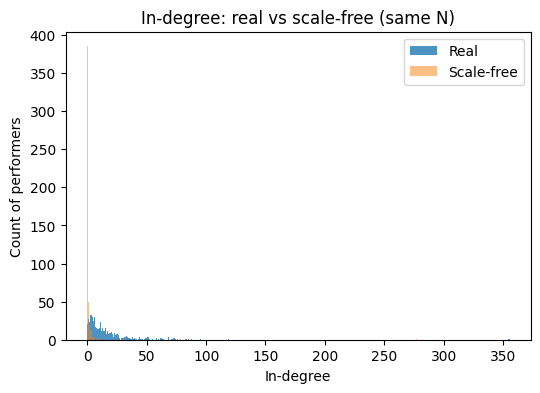

In [32]:
# Compare your in-degree to a scale-free network
# NetworkX's scale_free_graph returns a directed MultiDiGraph with heavy tails
G_sf_multi = nx.scale_free_graph(H.number_of_nodes(), seed=0)
# Simplify: remove self-loops and merge multi-edges
G_sf = nx.DiGraph((u, v) for u, v in G_sf_multi.edges() if u != v)

real_in = [d for _, d in H.in_degree()]
sf_in   = [d for _, d in G_sf.in_degree()]

plt.figure(figsize=(6,4))
plt.hist(real_in, bins=range(0, max(real_in)+2), align="left", alpha=0.8, label="Real")
plt.hist(sf_in,   bins=range(0, min(max(real_in), max(sf_in))+2), align="left", alpha=0.5, label="Scale-free")
plt.xlabel("In-degree"); plt.ylabel("Count of performers")
plt.title("In-degree: real vs scale-free (same N)")
plt.legend(); plt.show()

**ANSWER**: What to observe: The in-degree distribution is heavy-tailed (few artists attract many links). That matches scale-free behavior (preferential attachment), unlike a random network. Out-degree is editor-limited; in-degree reflects popularity/centrality and can run away.

In [29]:
# Top 5 most connected perfomers
top_in  = sorted(H.in_degree,  key=lambda kv: kv[1], reverse=True)[:5]
top_out = sorted(H.out_degree, key=lambda kv: kv[1], reverse=True)[:5]
print("Top 5 in-degree :", top_in)
print("Top 5 out-degree:", top_out)

Top 5 in-degree : [('AllMusic', 355), ('Led Zeppelin', 119), ('Bob Dylan', 95), ('Queen (band)', 88), ('Metallica', 85)]
Top 5 out-degree: [('Alice in Chains', 75), ('Deep Purple', 72), ('Black Sabbath', 61), ('Def Leppard', 53), ("Guns N' Roses", 52)]


In [30]:
# 10 pages with longest entries (by n_words attribute)
top_long = sorted(H.nodes(data="n_words"), key=lambda x: x[1], reverse=True)[:10]
print("10 longest pages:")
for name, nwords in top_long:
    print(f"{name:35s}  {nwords}")

10 longest pages:
Guns N' Roses                        60853
Coldplay                             47028
Queen (band)                         46197
Marilyn Manson (band)                46032
The Rolling Stones                   44022
U2                                   43048
Bob Dylan                            42509
David Bowie                          42408
Paul McCartney                       42396
Elton John                           41255


# Part 3: Visualizing the networks

*Exercise:* Let's build a simple visualization of the network
>1. For the sake of the visualisation, let's convert our network to *undirected graph* (tip: There is a NetworkX command to help you).
>   * *Note*: Keep the directed graph, we will use it in the following exercises.
>2. Use the NetworkX command `nx.spring_layout` or `nx.draw_kamada_kawai` to draw the resulting undirected network. (You can find [background on the algorithms here](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).)  
>   * Set up your plot so that node-size depends on the node *degree*.
>   * Make the node color depend on the `length of content` attribute. I recommend choosing a color scheme that is quite simple (e.g. the Sequential ones here: https://matplotlib.org/stable/users/explain/colors/colormaps.html)

<div class="alert alert-block alert-info">
For this exercise, I hope you'll do almost everything yourself. But it's OK to use an LLM for help with the coloring.
</div>

If you want to make things more fancy, note that Wikipedia writes that local minima is a problem for these graphs: "It is easy to see that force-directed algorithms produce a graph with minimal energy, in particular one whose total energy is only a local minimum. The local minimum found can be, in many cases, considerably worse than a global minimum, which translates into a low-quality drawing. For many algorithms, especially the ones that allow only down-hill moves of the vertices, the final result can be strongly influenced by the initial layout, that in most cases is randomly generated. The problem of poor local minima becomes more important as the number of vertices of the graph increases. **A combined application of different algorithms is helpful to solve this problem**. For example, using the Kamada–Kawai algorithm to quickly generate a reasonable initial layout and then the Fruchterman–Reingold algorithm to improve the placement of neighbouring nodes." (my emphasis) 

But don't worry if your network looks like a hairball (a.k.a a *ridiculogram*) for now, we'll dig deeper with visualization next time.

In [37]:
# make an undirected view
U = nx.Graph(H)   # undirected copy for visualization only

In [38]:
# compute sizes (degree) and colors (n_words)
# degree for sizing
deg = dict(U.degree())
sizes = [20 + 4*deg[n] for n in U.nodes()]  # tweak 20/4 if you want bigger/smaller

# article length for coloring
nwords = np.array([H.nodes[n]["n_words"] for n in U.nodes()])

# robust normalization (clip extremes with percentiles so the colorbar isn't dominated by outliers)
norm = Normalize(vmin=np.percentile(nwords, 5), vmax=np.percentile(nwords, 95))
cmap = plt.cm.viridis
colors = cmap(norm(nwords))

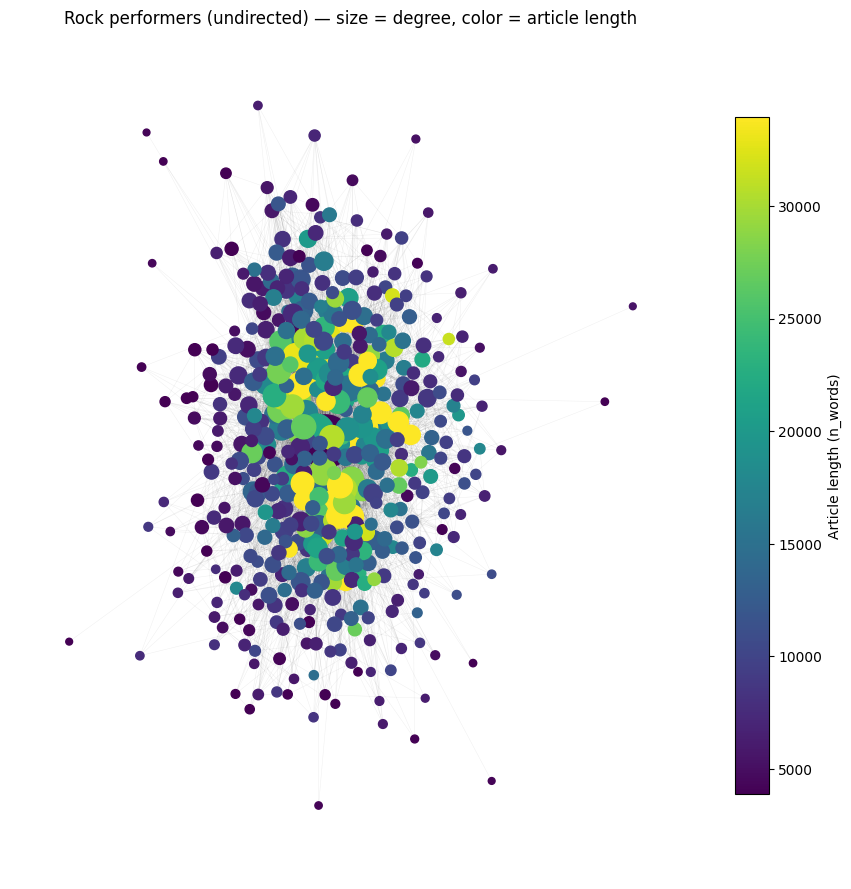

In [41]:
# layout + draw (spring) with colorbar hookup
# data to color by (n_words already built earlier)
vmin = np.percentile(nwords, 5)
vmax = np.percentile(nwords, 95)

fig, ax = plt.subplots(figsize=(11,11))

pos = nx.spring_layout(U, k=0.18, seed=42, iterations=100)

# edges
nx.draw_networkx_edges(U, pos, alpha=0.06, width=0.4, ax=ax)

# nodes: pass raw values + vmin/vmax + cmap
nodes = nx.draw_networkx_nodes(
    U, pos,
    node_size=sizes,
    node_color=nwords,   # raw values
    cmap=plt.cm.viridis,
    vmin=vmin, vmax=vmax,
    ax=ax
)

# colorbar attached to this mappable + axes
cbar = fig.colorbar(nodes, ax=ax, shrink=0.8)
cbar.set_label("Article length (n_words)")

ax.set_title("Rock performers (undirected) — size = degree, color = article length")
ax.set_axis_off()
plt.show()